Predict Long, Short or Stable position based on some indicators computed from historical price values.

- State : Features + Closing price
- Action : Pick Short, Long or Stable position
- Reward : (p1-p2)*position

shortfalls:
- No temporal modeling
- No portfolia management
- Very basic reward function
- Avg. Training reward flactuates due to intantenous rate of return differences used in the reward function.

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
from matplotlib import pyplot as plt

import reinforcement_learning.backtest as twp
from reinforcement_learning.utils import *

DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
TIME_GRAN = 24*60  # time granularity in minutes
TRAIN_START = 0 / TIME_GRAN  # take only afterwards
PRED_DAYS = 50  # num prediction days for the trained models
TEST_START = ((24*60) / TIME_GRAN) * PRED_DAYS 
NUM_ACTIONS = 3

df = read_dummy_data1(DATA_PATH, TIME_GRAN)
df_train = df.iloc[TRAIN_START:df.shape[0]-TEST_START,] 
df_test = df.iloc[df.shape[0]-TEST_START:,]
print(df_train.shape)
print(df_test.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 > There are 1014 rows
(964, 8)
(50, 8)


In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop, Adam

num_features = 7


model = Sequential()
model.add(Dense(64, init='lecun_uniform', input_shape=(num_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(NUM_ACTIONS, init='lecun_uniform'))
model.add(Activation('linear'))

rms = RMSprop()
adam = Adam()
model.compile(loss='mse', optimizer=rms)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="lecun_uniform", input_shape=(7,))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="lecun_uniform")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="lecun_uniform")`


In [23]:
import timeit

start_time = timeit.default_timer()

# set train and test data
train_data = df_train
test_data = df_test
start_timestep = 14

# training arguments
epochs = 50
batch_size = 10
gamma = 0.85  
epsilon = 0.9  # parameter setting initial random actions, that decays as learning 

# stores tuples of (S, A, R, S')
signal = pd.Series(index=np.arange(len(train_data)))

# replay memory
replay_memory = ReplayMemory(900)

# let the agent learn
learning_progress = []
for i in range(epochs):
    avg_sim_reward = AverageMeter()
    terminal_state = 0
    state, xdata, price_data = create_states(train_data)
    time_step = start_timestep
    
    #while game still in progress
    while(terminal_state == 0):
        
        # We are in state S
        # 1- Compute the next action based on state S with the network
        qval = model.predict(state, batch_size=1)
        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,NUM_ACTIONS) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
            
        # 2- Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        
        # 3- Compute the reward
        reward = get_reward(new_state, time_step, action, price_data, signal, eval=False)
#         print(" Action: {}, Signal: {}, Reward: {}".format(action, signal[time_step], reward))
        
        avg_sim_reward.update(reward)
        
        #Experience replay storage
        replay_memory.push(state, action, new_state, reward)
        state = new_state
        optimize_DQN(model, replay_memory, batch_size, gamma)
        
    learning_progress.append(avg_sim_reward.avg)
    print("Epoch #: %s SimReward: %f Epsilon: %f" % (i, avg_sim_reward.avg, epsilon))
    
    # decay epsilon
    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Epoch #: 0 SimReward: 0.000047 Epsilon: 0.900000
Epoch #: 1 SimReward: 0.000068 Epsilon: 0.880000
Epoch #: 2 SimReward: 0.000132 Epsilon: 0.860000
Epoch #: 3 SimReward: 0.000215 Epsilon: 0.840000
Epoch #: 4 SimReward: 0.000253 Epsilon: 0.820000
Epoch #: 5 SimReward: 0.000031 Epsilon: 0.800000
Epoch #: 6 SimReward: 0.000170 Epsilon: 0.780000
Epoch #: 7 SimReward: 0.000222 Epsilon: 0.760000
Epoch #: 8 SimReward: 0.000200 Epsilon: 0.740000
Epoch #: 9 SimReward: 0.000176 Epsilon: 0.720000
Epoch #: 10 SimReward: 0.000133 Epsilon: 0.700000
Epoch #: 11 SimReward: 0.000251 Epsilon: 0.680000
Epoch #: 12 SimReward: 0.000231 Epsilon: 0.660000
Epoch #: 13 SimReward: 0.000298 Epsilon: 0.640000
Epoch #: 14 SimReward: 0.000275 Epsilon: 0.620000
Epoch #: 15 SimReward: 0.000262 Epsilon: 0.600000
Epoch #: 16 SimReward: 0.000248 Epsilon: 0.580000
Epoch #: 17 SimReward: 0.000261 Epsilon: 0.560000
Epoch #: 18 SimReward: 0.000294 Epsilon: 0.540000
Epoch #: 19 SimReward: 0.000212 Epsilon: 0.520000
Epoch #: 2

In [24]:
signal = pd.Series(index=np.arange(len(test_data)))
state, xdata, price_data = create_states(test_data, test=True)

time_step = 1
terminal_state = 0
avg_test_reward = AverageMeter()
while(terminal_state == 0):
    #We are in state S
    # 1- Compute the next action based on state S with the network
    qval = model.predict(state, batch_size=1)
    action = (np.argmax(qval))
    # 2- Take action, observe new state S'
    new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
    # 3- Compute the reward
#     reward = get_reward(new_state, time_step, action, close_prices, signal, eval=False)
#     avg_test_reward.update(reward)
    state = new_state
#     print(" # Average test reward: {}".format(avg_test_reward.avg))
    
final_reward = get_reward(new_state, time_step, action, price_data, signal, eval=True)
print(" # Final test reward: {}".format(final_reward))

 # Final test reward: 34.0


In [25]:
price_data = pd.Series(price_data)
bt = twp.Backtest(price_data, signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

unique, counts = np.unique(filter(lambda v: v==v, signal.values), return_counts=True)
print(np.asarray((unique, counts)).T)

[[ -1.  34.]
 [  0.  16.]]


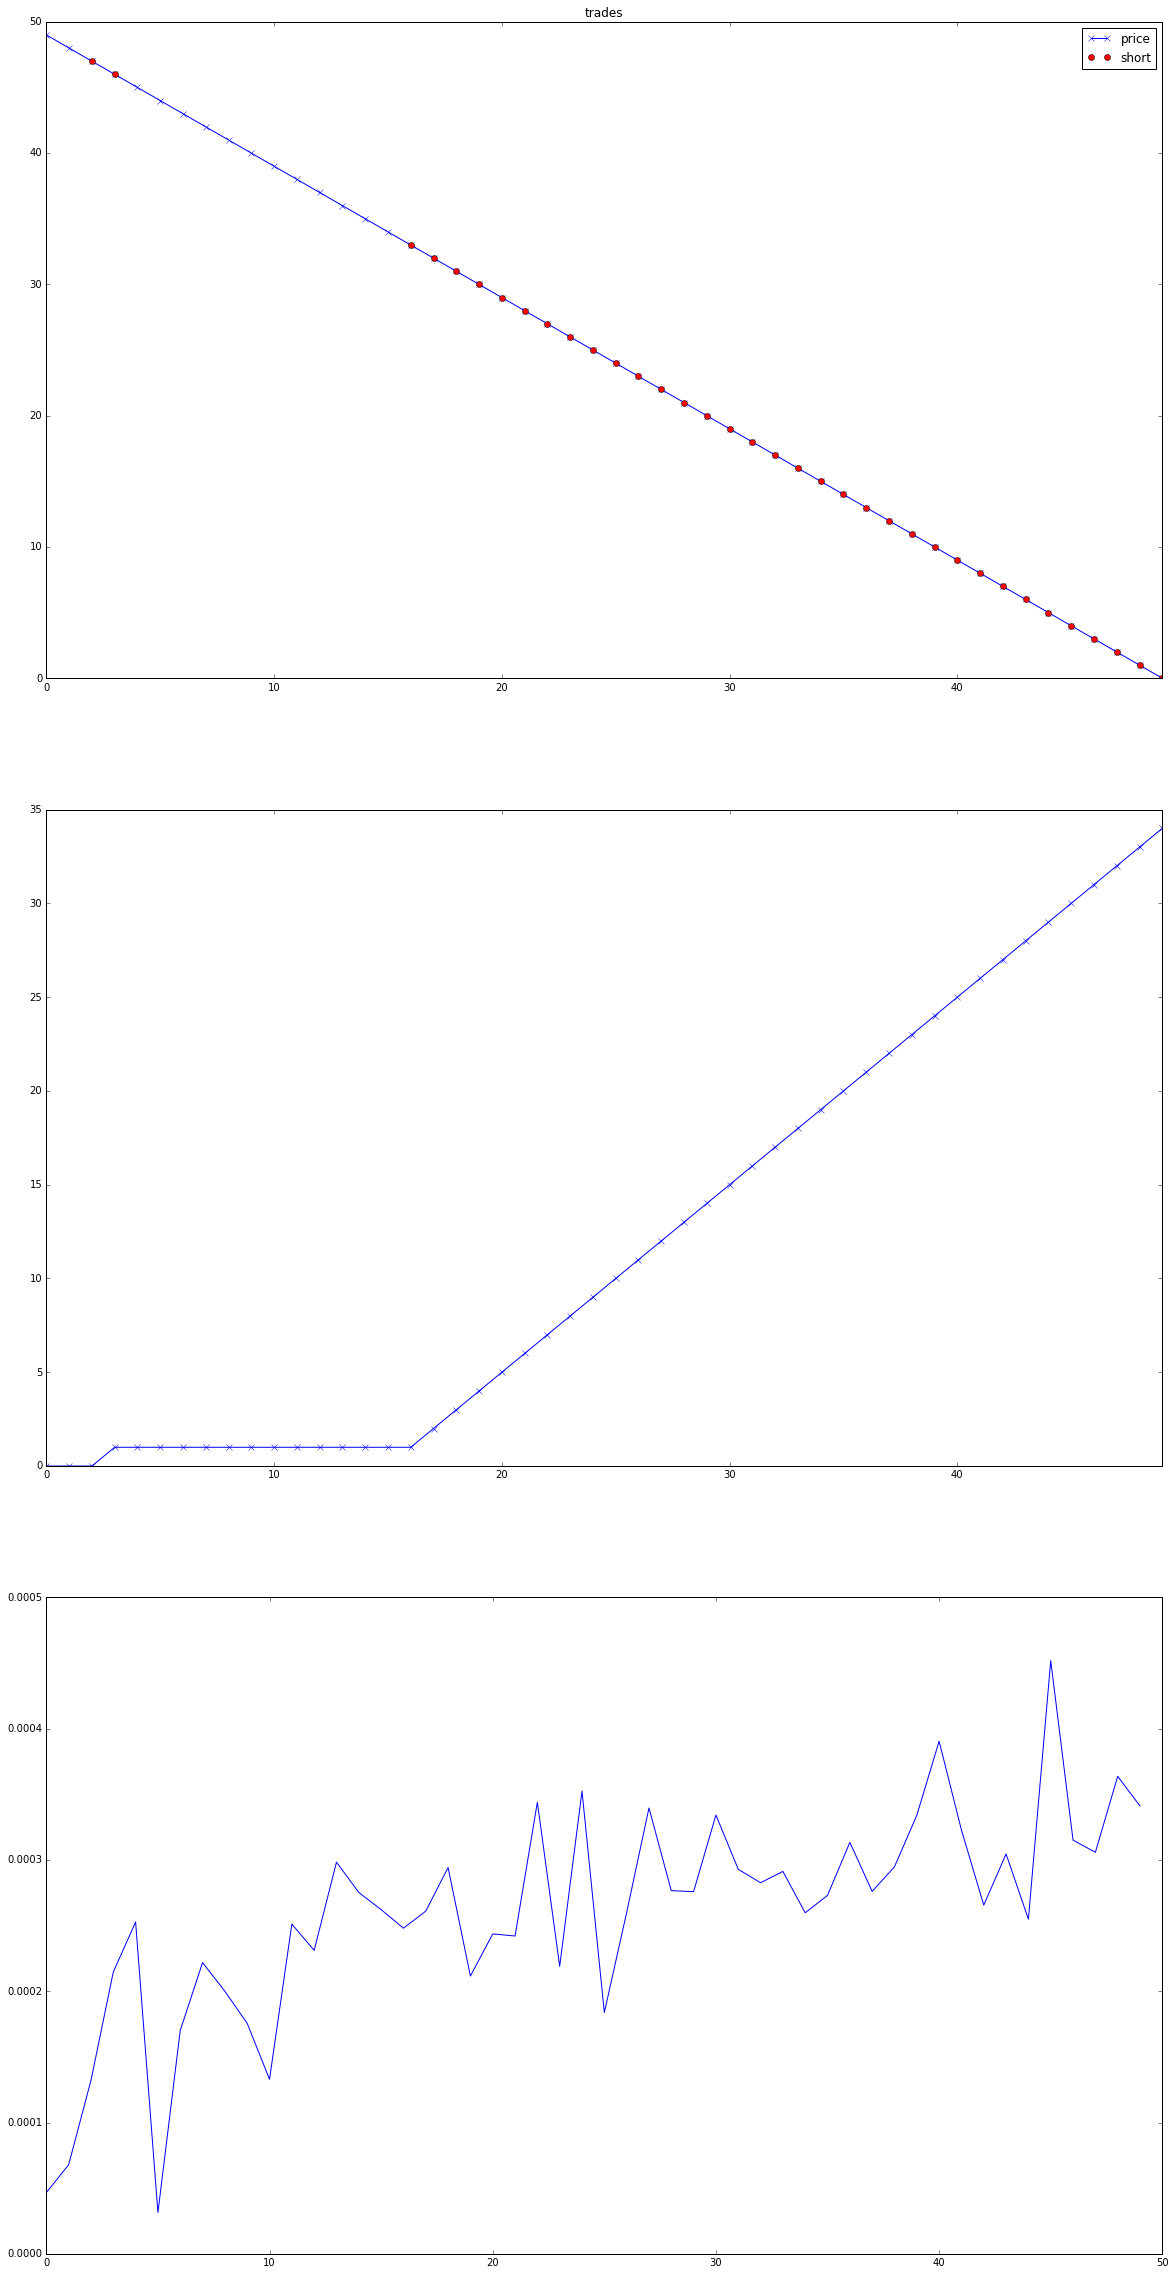

In [26]:
plt.figure(figsize=[20, 40])
plt.subplot(3,1,1)
bt.plotTrades()

plt.subplot(3,1,2)
bt.pnl.plot(style='x-')

plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.savefig('reinforcement_learning/plt/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
# plt.show()